## `Fitty.jl`: Nonlinear least squares regression in Julia

**Raibatak Das - 2022-JUL-08**

This notebook describes how to use `Fitty.jl` to fit data using nonlinear least squares regression. Such problems are common in many areas of physical and biological sciences where experimental data is fit to a mathematical model to estimate model parameters. `Fitty.jl` aims to provide an easy-to-use and robust set of tools for this class of problems within the Julia ecosystem. 

### Features (and limitations)

`Fitty.jl` is compact and designed to do a small number of things well. It currently provides the following features:  
- A well-tested and robust implementation of a Levenberg-Marquardt like trust-region algorithm
- Ordinary and weighted nonlinear least squares minimization with parameter bounds
- Bayesian posterior parameter density estimation using Bayesian Bootstrap

`Fitty.jl` does not currently support:  
- Non-constant error models of variance, such as constant + proportional, or exponential error models   
  However, see below for an example of fitting log-transformed data, which is equivalent to an exponential error model
- Model functions that use non-Julia libraries (eg: BLAS) that are not compatible with `ForwardDiff.jl`

### Quick start: Rosenbrock function

The Rosenbrock function (aka the Rosenbrock 🍌 function) defined below is a standard test problem for nonlinear least squares minimization:
$$ f(x, y) = (1 - x)^2 + 100(y - x^2)^2 $$
This function has a non-convex shape with a hard to find global minima at (1, 1). The funciton $f(x, y)$ can be expressed as a vector of residuals:
$$\begin{aligned}
\epsilon_1 & = 1 - x \\
\epsilon_2 & = 100(y - x^2)
\end{aligned}$$

whose sum of squares SSR = $\epsilon_1^2 + \epsilon_2^2$ is to be minimized. The next code block sets up this problem and uses `Fitty` to estimate the optimal $x$ and $y$ starting with a non-optimal guess

In [1]:
include("Fitty.jl")
using .Fitty, CSV, DataFrames, DifferentialEquations, Distributed, LaTeXStrings, KernelDensity, Plots
import Distributions: Normal, pdf, quantile
import StatsBase: ecdf
import NaNMath as nm

In [2]:
# Uncomment to reload only the Fitty module
# include("Fitty.jl")
# using .Fitty

In [3]:
# Define Rosenbrock function
Rosenbrock(θ) = [1 - θ[1], 100*(θ[2] - θ[1]^2)]

# Minimize SSR starting with a non-optimal guess
guess = [-1.5, 1] # Starting guess away from global minima
@time fit = Fitty.nlsqfit(Rosenbrock, guess);

Fit converged in 49 steps from intial guess [-1.5, 1.0]
[0.9999999818593247, 0.9999999637136757]

  2.338058 seconds (7.81 M allocations: 505.298 MiB, 13.14% gc time, 99.89% compilation time: 2% of which was recompilation)


The console output shows some diagnostic information, such as the number of steps needed for convergence and the function value at the estimated minima, and a table of parameter estimates. 

The output of `Fit` contains a full history of the optimizer trajectory in parameter space, and the SSR values at each step. These are plotted below:

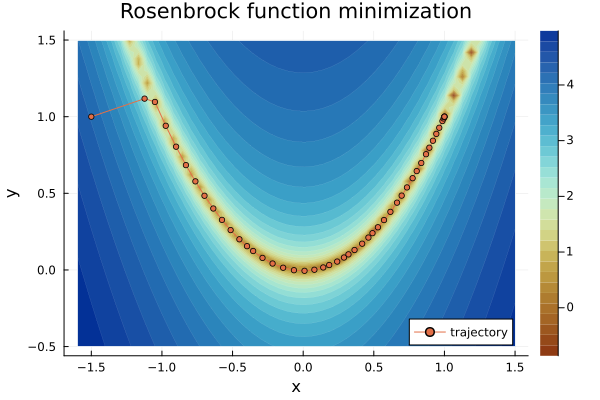

In [4]:
x = range(-1.6, 1.5, length = 51)
y = range(-0.5, 1.5, length = 51)
f(θ₁, θ₂) = log10(sum((Rosenbrock([θ₁, θ₂])).^2))
z = [f(x, y) for y = y for x = x]
p = contourf(x, y, z, levels = 30, alpha = 0.95, 
         lc = :white, lw = 0, color = :roma25)
plot!(fit.traj[:,1], fit.traj[:, 2], 
      marker = :circle, ms = 3,
      label = "trajectory")
plot!(title = "Rosenbrock function minimization", 
      xlabel = "x", ylabel = "y")

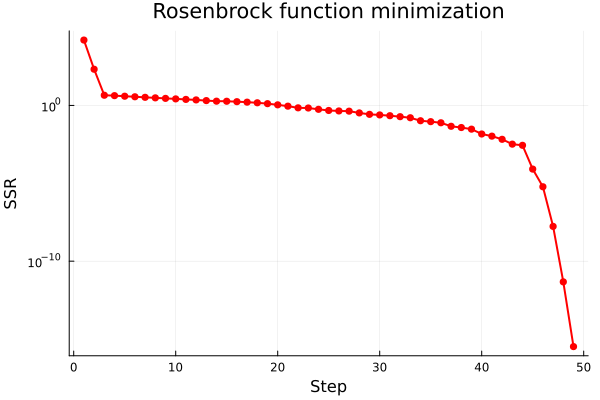

In [5]:
p = plot(fit.ssrvals, lw = 2, 
    marker = :circle, 
    color = :red, msc = :red,
    label = "",
    xaxis = "Step",
    yaxis = ("SSR", :log),
    title = "Rosenbrock function minimization")

### Data fitting to a nonlinear model

The next example shows how to fit experimental data to a nonlinear model. 

For this example, we use the `Puromycin` dataset that reports the velocity of an enzymatic reaction at different substrate concentrations. The enzyme was treated with Puromycin or left unreated. The data is loaded from the the file `Puromycin.csv`. Substrate concentrations are in units of parts per million (ppm) and reaction velocities are  in counts/minute$^2$. 

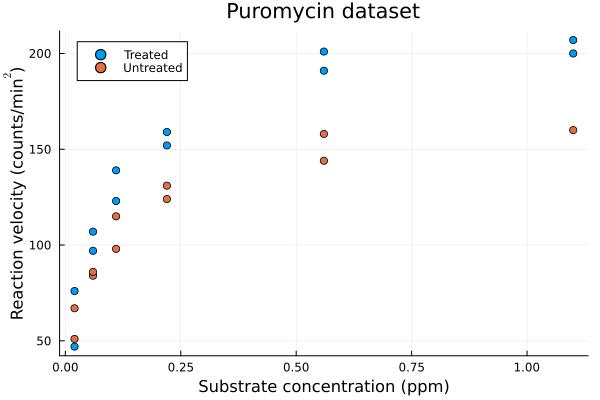

In [6]:
# Import Puromycin dataset and plot data
src = "data/Puromycin.csv"
puro = CSV.read(src, DataFrame)

# Split by condition
trt = filter(row -> row.Condition == "treated", puro)
untrt = filter(row -> row.Condition == "untreated", puro)

# Plot each dataset
x, y = trt.Concentration, trt.Velocity
plot(x, y, linetype = :scatter, label = "Treated")
x, y = untrt.Concentration, untrt.Velocity
plot!(x, y, linetype = :scatter, label = "Untreated")
plot!(xaxis = "Substrate concentration (ppm)", 
      yaxis = L"Reaction velocity (counts/min$^2$)",
      title = "Puromycin dataset")

Fit each dataset to the Michelis Menten model that relates the velocity $v$ to the substrate concentration $c$:
$$ v = \frac{V_{\text{max}} \cdot c}{K_m + c} $$

where $V_{\text{max}}$ is the maximal reaction velocity, and the $K_m$ is the Michelis constant usually interpreted as the substrate concentration at which the reaction velocity is half-maximal ($v = V_{\text{max}}/2$).

First, define the model and a residual function

In [7]:
# Michelis-Menten model
model(θ, c) = @. θ.Vmax * c / (θ.Km + c)

# Define a general residual function
residual(θ, df) = df.Velocity - model(θ, df.Concentration)

residual (generic function with 1 method)

Fit each dataset

In [8]:
# Fit treated and untreated datasets
guess = (Vmax = 150, Km = 1)
@time fits = [Fitty.nlsqfit(residual, guess, data = df, lb = 0, bootstrap = true) for df in (trt, untrt)];

Fit converged in 17 steps from intial guess [150.0, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Vmax       [0.0, Inf]  212.684    6.94716     [206.864, 217.237]
 2 │ Km         [0.0, Inf]  0.0641213  0.00828095  [0.0544728, 0.0716725]

Sum of squared residuals = 1.195e+03
Degrees of freedom (# data points - # variabe parameters) = 12 - 2 = 10
Residual standard error = 1.093e+01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates
Fit converged in 17 steps from intial guess [150.0, 1.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Vmax       [0.0, Inf]  160.28     6.48025     [153.771, 165.332]
 2 │ Km         [0.0, Inf]  0.0477082  0.00778187  [0.0378829, 0.0553385]

Sum of squared residuals = 8.596e+02
Degrees of freedom (# data points - # variabe parameters) = 11 - 2 = 9
Residual standard error = 9.773e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates
  3.805029 seconds (18.49 M allocations: 3.444 GiB, 8.07% gc time, 70.07% compilation time)


Parameter order does not matter when using `NamedTuple` as input. Therefore, the function call below is equivalent to the one above

In [16]:
# Fit treated and untreated datasets
guess = (Km = 1, Vmax = 150)
@time fits = [Fitty.nlsqfit(residual, guess, data = df, lb = 0, bootstrap = true) for df in (trt, untrt)];

Fit converged in 17 steps from intial guess [1.0, 150.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Km         [0.0, Inf]  0.0641213  0.00828095  [0.0442138, 0.0761921]
 2 │ Vmax       [0.0, Inf]  212.684    6.94716     [199.141, 220.62]

Sum of squared residuals = 1.195e+03
Degrees of freedom (# data points - # variabe parameters) = 12 - 2 = 10
Residual standard error = 1.093e+01
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates
Fit converged in 17 steps from intial guess [1.0, 150.0]
2000 bootstrap fits converged out of 2000 tries
Fit results: 

Table with 5 columns and 2 rows:
     Parameter  Bounds      Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ Km         [0.0, Inf]  0.0477082  0.00778187  [0.0299349, 0.0614786]
 2 │ Vmax       [0.0, Inf]  160.28     6.48025     [146.659, 169.271]

Sum of squared residuals = 8.596e+02
Degrees of freedom (# data points - # variabe parameters) = 11 - 2 = 9
Residual standard error = 9.773e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates
  1.383256 seconds (9.88 M allocations: 2.914 GiB, 12.04% gc time, 17.96% compilation time)


Plot fits

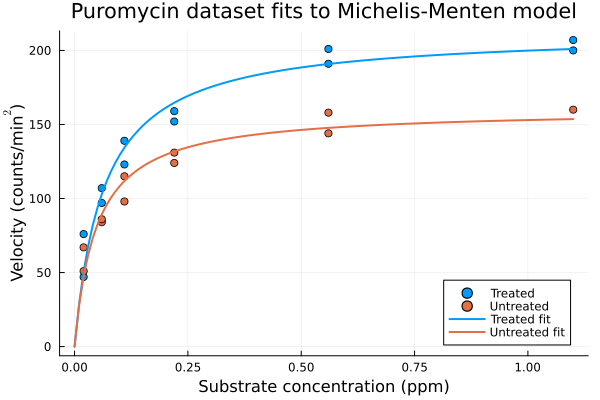

In [17]:
# Plot data
x, y = trt.Concentration, trt.Velocity
plot(x, y, linetype = :scatter, label = "Treated")
x, y = untrt.Concentration, untrt.Velocity
plot!(x, y, linetype = :scatter, label = "Untreated")

# Generate predictions
x = 0:0.01:1.1
ypred = [model(f.fit, x) for f in fits]
colors = palette(:default)
plot!(x, ypred[1], lw = 2, color = colors[1], label = "Treated fit")
plot!(x, ypred[2], lw = 2, color = colors[2], label = "Untreated fit")

plot!(xaxis = "Substrate concentration (ppm)", 
      yaxis = L"Velocity (counts/min$^2$)", 
      title = "Puromycin dataset fits to Michelis-Menten model")

Plot prediction -vs- observed reaction velocity

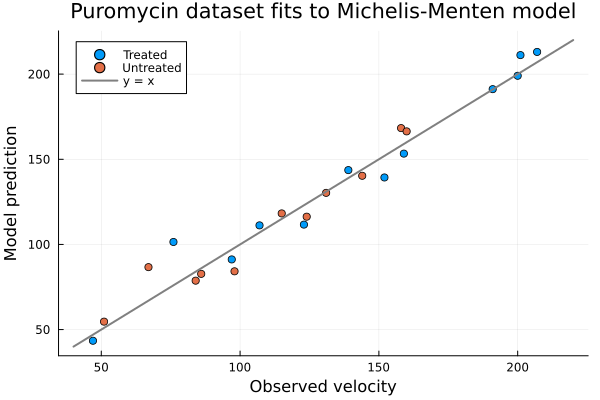

In [18]:
# Plot data
x = trt.Velocity
y = x + fits[1].residuals
plot(x, y, linetype = :scatter, label = "Treated")
x = untrt.Velocity
y = x + fits[2].residuals
plot!(x, y, linetype = :scatter, label = "Untreated")
x = [40, 220]
plot!(x, x, color = :gray, lw = 2, label = "y = x")
plot!(xaxis = "Observed velocity", 
      yaxis = "Model prediction", 
      title = "Puromycin dataset fits to Michelis-Menten model")

Plot residuals

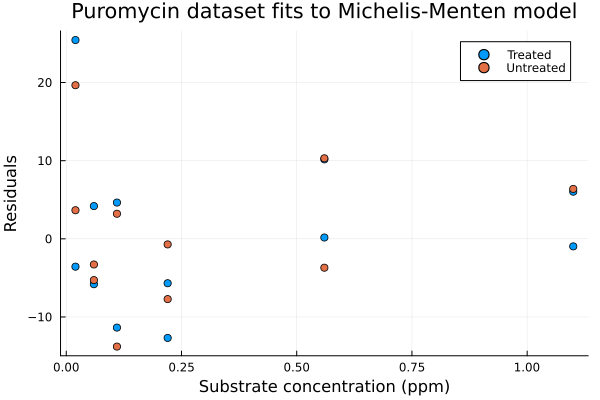

In [19]:
# Plot data
x, y = trt.Concentration, fits[1].residuals
plot(x, y, linetype = :scatter, label = "Treated")
x, y = untrt.Concentration, fits[2].residuals
plot!(x, y, linetype = :scatter, label = "Untreated")

plot!(xaxis = "Substrate concentration (ppm)", 
      yaxis = "Residuals", 
      title = "Puromycin dataset fits to Michelis-Menten model")

Plot parameter posterior distributions

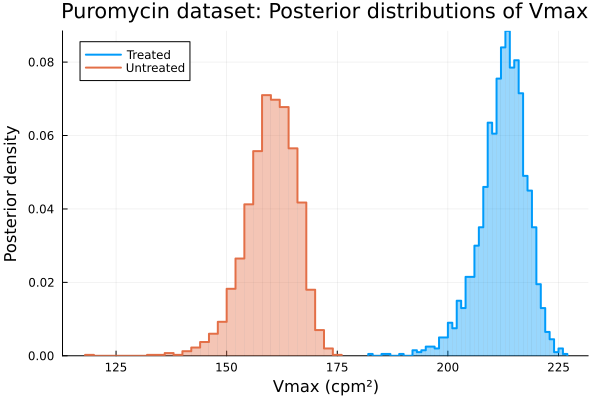

In [20]:
post = [Fitty.posteriorPDF(f) for f in fits]
nbins = 40
histogram(post[1].Vmax, bins = nbins, norm = :pdf, alpha = 0.4, lw = 0, label = "")
histogram!(post[2].Vmax, bins = nbins, norm = :pdf, alpha = 0.4, lw = 0, label = "")
colors = palette(:default)
stephist!(post[1].Vmax, bins = nbins, norm = :pdf, color = colors[1], lw = 2, label = "Treated")
stephist!(post[2].Vmax, bins = nbins, norm = :pdf, color = colors[2], lw = 2, label = "Untreated")
plot!(xaxis = "Vmax (cpm²)", 
      yaxis = "Posterior density",
      title = "Puromycin dataset: Posterior distributions of Vmax")

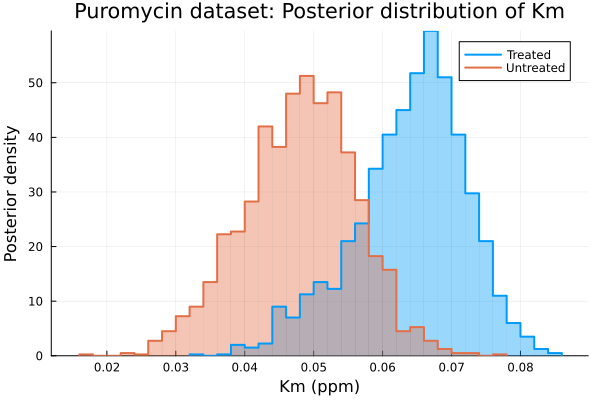

In [21]:
nbins = 40
histogram(post[1].Km, bins = nbins, norm = :pdf, alpha = 0.4, lw = 0, label = "")
histogram!(post[2].Km, bins = nbins, norm = :pdf, alpha = 0.4, lw = 0, label = "")
colors = palette(:default)
stephist!(post[1].Km, bins = nbins, norm = :pdf, color = colors[1], lw = 2, label = "Treated")
stephist!(post[2].Km, bins = nbins, norm = :pdf, color = colors[2], lw = 2, label = "Untreated")
plot!(xaxis = "Km (ppm)", 
      yaxis = "Posterior density",
      title = "Puromycin dataset: Posterior distribution of Km")

Print parameter CIs

In [22]:
# Bayesian credible intervals
for f in fits
    println(f.BayesCI)
end

[0.04421382990176842 0.07619207190472352; 199.14146075503518 220.61953798089718]
[0.029934859205604403 0.06147860684423622; 146.65898345503956 169.27067752838119]


Overlay kernel density plots

In [23]:
# Estimate kernel densities of bootstrap 
Vmax_untrt_kde = kde(post[1].Vmax)
Km_untrt_kde = kde(post[1].Km)
Vmax_trt_kde = kde(post[2].Vmax)
Km_trt_kde = kde(post[2].Km);

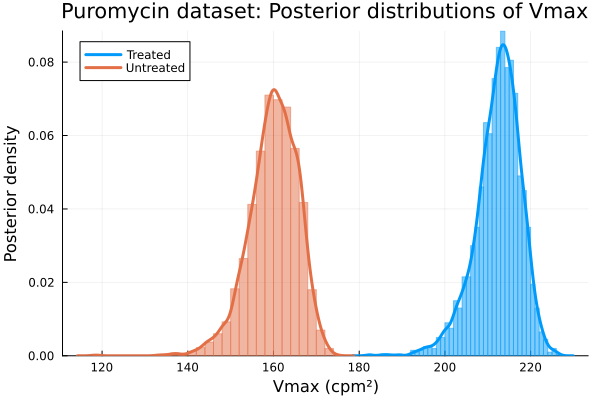

In [24]:
nbins = 40
histogram(post[1].Vmax, bins = nbins, lc = :match, alpha = 0.5, norm = :pdf, label = "")
histogram!(post[2].Vmax, bins = nbins, lc = :match, alpha = 0.5, norm = :pdf, label = "")
colors = palette(:default)
y = Vmax_untrt_kde
plot!(y.x, y.density, lw = 3, color = colors[1], label = "Treated")
y = Vmax_trt_kde
plot!(y.x, y.density, lw = 3, color = colors[2], label = "Untreated")
colors = palette(:default)
plot!(xaxis = "Vmax (cpm²)", 
      yaxis = "Posterior density",
      title = "Puromycin dataset: Posterior distributions of Vmax")

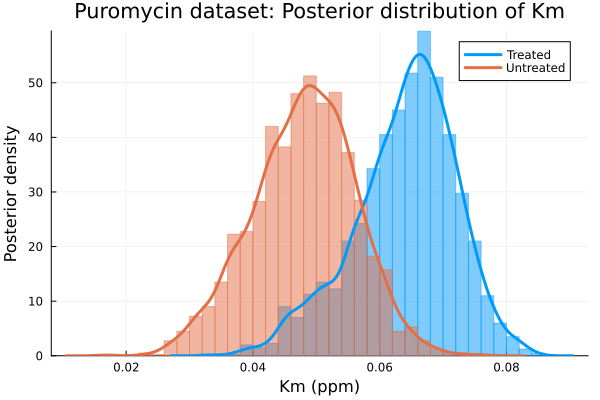

In [25]:
nbins = 40
histogram(post[1].Km, bins = nbins, lc = :match, alpha = 0.5, norm = :pdf, label = "")
histogram!(post[2].Km, bins = nbins, lc = :match, alpha = 0.5, norm = :pdf, label = "")
colors = palette(:default)
y = Km_untrt_kde
plot!(y.x, y.density, lw = 3, color = colors[1], label = "Treated")
y = Km_trt_kde
plot!(y.x, y.density, lw = 3, color = colors[2], label = "Untreated")
plot!(xaxis = "Km (ppm)", 
      yaxis = "Posterior density",
      title = "Puromycin dataset: Posterior distribution of Km")

Plots of joint posterior density

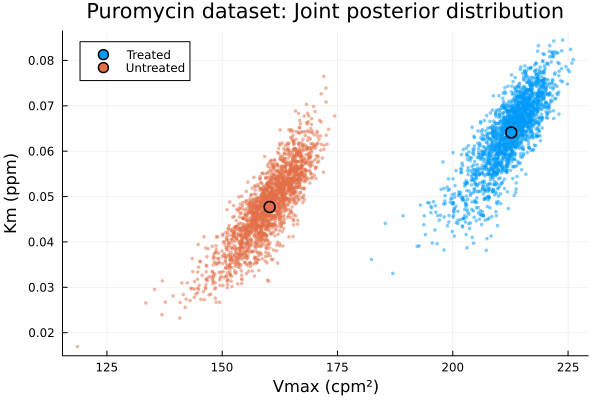

In [26]:
p1, p2 = post
scatter(p1.Vmax, p1.Km, label = "",
        ms = 2, msw = 0, alpha = 0.5)
scatter!(p2.Vmax, p2.Km, label = "",
        ms = 2, msw = 0, alpha = 0.5)
colors = palette(:default)
f1 = fits[1].fit
scatter!([f1.Vmax], [f1.Km], color = colors[1], 
          ms = 6, msw = 2,
          label = "Treated")
f2 = fits[2].fit
scatter!([f2.Vmax], [f2.Km], color = colors[2], 
          ms = 6, msw = 2, 
          label = "Untreated")
plot!(xaxis = "Vmax (cpm²)", 
      yaxis = "Km (ppm)",
      title = "Puromycin dataset: Joint posterior distribution")

### Fit multivariate data to an ordinary differential equation model

The next example demonstrates two features:
- Fitting to multivariate data (i.e. multiple columns), and
- Fitting to an ordinary differential equation (ODE)

The dataset for this example if from Table A1.6 of Bates and Watts (1988). These data report the kinetics of thermal isomerization of $\alpha$-pinene into several products whose relative concentrations are reported at 8 timepoints. The sample is assumed to be 100% $\alpha$-Pinene at $t  = 0$. 

The next code block loads this data and plots the timecourse of each species

In [27]:
# Load alpha-pinene dataset
src = "data/Pinene.csv"
pinene = CSV.read(src, DataFrame)

8×7 DataFrame
 Row │ Time   TimeUnits  alphaPinene  Dipentene  Alloocimene  Pyronene  Dimer  ⋯
     │ Int64  String3    Float64      Float64    Float64      Float64   Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1230  min              88.35        7.3          2.3       0.4     1.7 ⋯
   2 │  3060  min              76.4        15.6          4.5       0.7     2.8
   3 │  4920  min              65.1        23.1          5.3       1.1     5.8
   4 │  7800  min              50.4        32.9          6.0       1.5     9.3
   5 │ 10680  min              37.5        42.7          6.0       1.9    12.0 ⋯
   6 │ 15030  min              25.9        49.1          5.9       2.2    17.0
   7 │ 22620  min              14.0        57.4          5.1       2.6    21.0
   8 │ 36420  min               4.5        63.1          3.8       2.9    25.7
                                                                1 column omitted

Plot time course

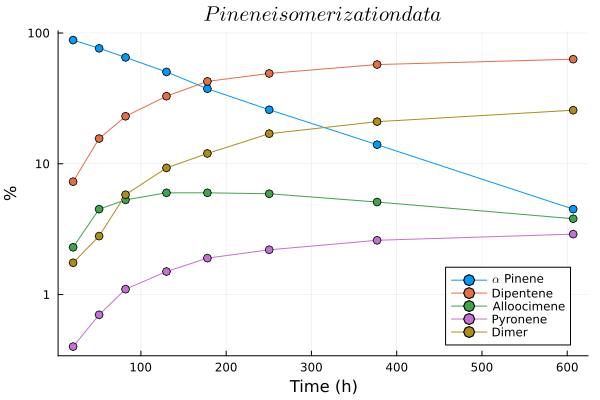

In [28]:
hr, y = pinene.Time/60, pinene.alphaPinene
plot(hr, y, marker = :o, label = L"$\alpha$"*" Pinene")
for c = names(pinene)[end-3:end]
    y = pinene[:, c]
    plot!(hr, y, marker = :o, label = c)
end
plot!(xaxis  = "Time (h)", 
      yaxis  = ("%", :log), 
      yticks = ([1, 10, 100], ["1", "10", "100"]), 
      legend = :bottomright, 
      title  = L"Pinene isomerization data")

These data are fit to a system of linear ordinary differential equations (ODEs) that encode the model below:  
![alpha-pinene isomerization model](Figures/alpha-pinene-model.svg)

Where the parameters $k_j$ are first order rate constants. The systems of ODEs for this model is:
$$\begin{aligned}
\dot{f_1} & = -(k_1 + k_2) f_1 \\
\dot{f_2} & = k_1 f_1 \\
\dot{f_3} & = k_2 f_1 - k_3 f_3 - k_4 f_3 + k_5 f_5\\
\dot{f_4} & = k_3 f_3 \\
\dot{f_5} & = k_4 f_3 - k_5 f_5
\end{aligned}$$

where $f_1$ is % alpha Pinene, $f_2$ is % dipentene, $f_3$ is % alloocimene, $f_4$ is % pyronene and $f_5$ is % dimer, with the initial condition, $f(0) = [100, 0, 0, 0, 0]$. 

The next code blocks define a function to solve this system for an input vector of rate constants, and a residual function that uses the  solution to compute residuals against the reported data. The ODEs are numerically integrated using the `DifferentialEquations.jl` package. Computed residuals are returned concatenated into a single column vector for the optimizer. 

In [29]:
# Define rate laws -> the RHS of ODEs
function dydt!(dy, y, θ, t)
    f1, f2, f3, f4, f5 = y
    k1, k2, k3, k4, k5 = θ.k1, θ.k2, θ.k3, θ.k4, θ.k5
    dy[1] = -(k1 + k2)*f1
    dy[2] = k1*f1
    dy[3] = k2*f1 - k3*f3 - k4*f3 + k5*f5 
    dy[4] = k3*f3 
    dy[5] = k4*f3 - k5*f5
end

# Define Function to solve ODEs for input rate constants
function solveODE(guess, y0 = [100, 0, 0, 0, 0], tspan = (0, 600))
    prob = ODEProblem(dydt!, y0, tspan, k)
    sol = solve(prob, alg_hints = [:stiff], 
                reltol = 1e-8, abstol = 1e-8)
    return sol
end

solveODE (generic function with 3 methods)

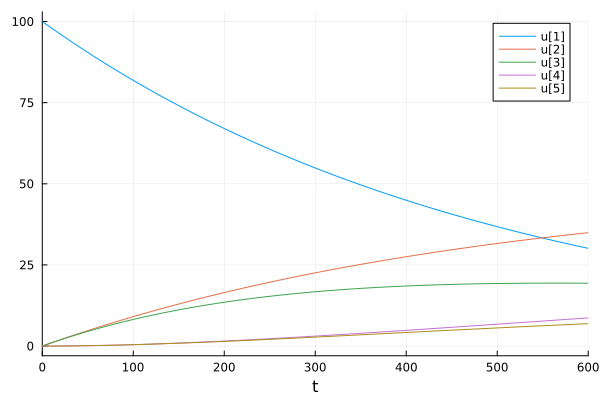

In [30]:
# Test with some guesses for model parameters
k = (k1 = 0.001, k2 = 0.001, k3 = 0.001, 
     k4 = 0.001, k5 = 0.001)
sol = solveODE(k)
plot(sol)

In [31]:
# Define residual function
function residual(θ, df = pinene, logScaled = false)
    # Set up and solve ODEs
    y0 = [100, 0, 0, 0, 0]
    tobs = df.Time
    nobs = length(tobs)
    tspan = [0, maximum(tobs)]
    prob = ODEProblem(dydt!, y0, tspan, θ)
    sol = solve(prob, alg_hints = [:stiff], 
                reltol = 1e-8, abstol = 1e-8,
                saveat = tobs; verbose = false)
    # Reshape to match the shape of data
    if length(sol) > 1
        ypred = transpose(stack(sol.u))
    else
        ypred = repeat(y0', nobs)
    end
    yobs = Matrix(df[:, [:alphaPinene, :Dipentene, :Alloocimene, :Pyronene, :Dimer]])
    if logScaled
        err = nm.log10.(yobs) - nm.log10.(ypred)
    else
        err = yobs - ypred
    end
    return err[:] # Concatenate residuals into a column vector
end

# Check (Should return a 
#residual([1e-4 for j in 1:5])

residual (generic function with 3 methods)

Constrain rate constants to be positive and fit to data

In [32]:
# Fit to data
guess = (k1 = 1e-4, k2 = 1e-4, k3 = 1e-4, 
         k4 = 1e-4, k5 = 1e-4)
@time fit = Fitty.nlsqfit(residual, guess, data = pinene, lb = 0, bootstrap = false);

Fit converged in 10 steps from intial guess [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
Fit results: 

Table with 5 columns and 5 rows:
     Parameter  Bounds      Estimate     StdErr      CI
   ┌───────────────────────────────────────────────────────────────────────────
 1 │ k1         [0.0, Inf]  5.92585e-5   5.07117e-7  [5.82646e-5, 6.02524e-5]
 2 │ k2         [0.0, Inf]  2.9634e-5    4.91112e-7  [2.86715e-5, 3.05966e-5]
 3 │ k3         [0.0, Inf]  2.04729e-5   3.09504e-6  [1.44067e-5, 2.65391e-5]
 4 │ k4         [0.0, Inf]  0.000274467  2.32064e-5  [0.000228983, 0.000319951]
 5 │ k5         [0.0, Inf]  3.99791e-5   8.3839e-6   [2.3547e-5, 5.64113e-5]

Sum of squared residuals = 1.987e+01
Degrees of freedom (# data points - # variabe parameters) = 40 - 5 = 35
Residual standard error = 7.535e-01
95.0% confidence intervals computed using normal approximation
  7.751323 seconds (21.09 M allocations: 1.339 GiB, 9.10% gc time, 99.86% compilation time)


Overlay predictions with fitted parameters on data

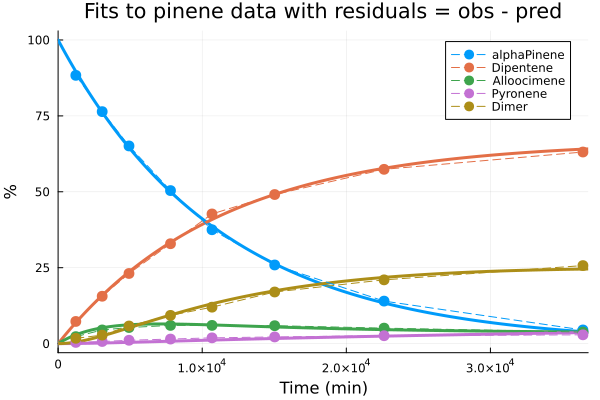

In [33]:
# Simulate ODEs with fitted parameters
y0 = [100, 0, 0, 0, 0]
tspan = (0, 1.01*maximum(pinene.Time))
prob = ODEProblem(dydt!, y0, tspan, fit.fit)
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8)
plot(sol, lw = 3, label = "")
t = pinene.Time
colors = palette(:default)
for (j, c) = enumerate(names(pinene)[3:end])
    y = pinene[:, c]
    plot!(t, y, marker = :circle, ms = 6,  msw = 0, color = colors[j], linestyle = :dash, label = c)
end
plot!(xaxis = "Time (min)", 
      yaxis = "%",
      legend = :topright, 
      title = "Fits to pinene data with residuals = obs - pred")

Fit with residuals on a log scale, i.e. under an exponential error model

In [34]:
Lres = θ -> residual(θ, pinene, true)
@time logFit = Fitty.nlsqfit(Lres, guess, lb = 0);

Fit converged in 8 steps from intial guess [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
(k1 = 5.749928502341187e-5, k2 = 3.354212258619123e-5, k3 = 4.980410338053273e-5, k4 = 0.0004657990036532735, k5 = 6.239519961655845e-5)
  6.114051 seconds (17.21 M allocations: 1.084 GiB, 7.58% gc time, 99.83% compilation time)


Plot this fit overlaid on data

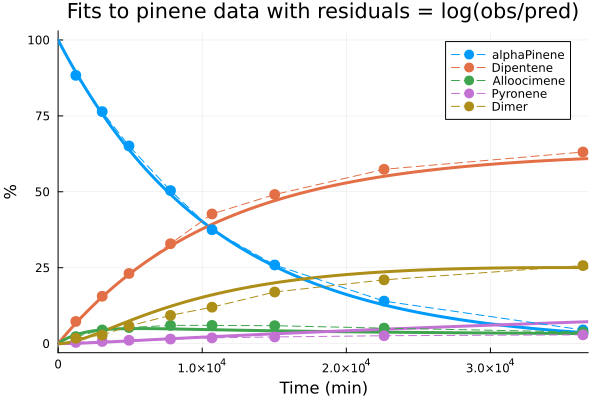

In [35]:
# Simulate ODEs with fitted parameters
tspan = (0, 1.01*maximum(pinene.Time))
prob = ODEProblem(dydt!, y0, tspan, logFit.fit)
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8)

plot(sol, lw = 3, label = "")
t = pinene.Time
colors = palette(:default)
for (j, c) = enumerate(names(pinene)[3:end])
    y = pinene[:, c]
    plot!(t, y, marker = :circle, ms = 6,  msw = 0, color = colors[j], linestyle = :dash, label = c)
end
plot!(xaxis = "Time (min)", 
      yaxis = "%",
      title = "Fits to pinene data with residuals = log(obs/pred)")

Same plot with log y scale

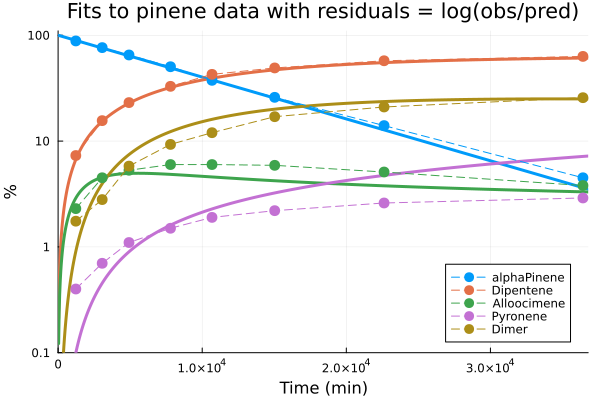

In [36]:
plot!(yaxis = ("%", [0.1, 110], :log),
      yticks = ([0.1, 1, 10, 100], ("0.1", "1", "10", "100")),
      legend = :bottomright)

Generate bootstrap distribution of parameter estimates

In [37]:
# Test
nboot = 10
@time bootFits = Fitty.nlsqfit(residual, guess, data = pinene, lb = 0, bootstrap = true, nboot = nboot);

Fit converged in 10 steps from intial guess [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
10 bootstrap fits converged out of 10 tries
Fit results: 

Table with 5 columns and 5 rows:
     Parameter  Bounds      Estimate     StdErr      CI
   ┌───────────────────────────────────────────────────────────────────────────
 1 │ k1         [0.0, Inf]  5.92585e-5   5.07117e-7  [5.89838e-5, 5.9586e-5]
 2 │ k2         [0.0, Inf]  2.9634e-5    4.91112e-7  [2.88762e-5, 2.98637e-5]
 3 │ k3         [0.0, Inf]  2.04729e-5   3.09504e-6  [1.78159e-5, 2.34618e-5]
 4 │ k4         [0.0, Inf]  0.000274467  2.32064e-5  [0.000233904, 0.000328521]
 5 │ k5         [0.0, Inf]  3.99791e-5   8.3839e-6   [2.70298e-5, 5.55941e-5]

Sum of squared residuals = 1.987e+01
Degrees of freedom (# data points - # variabe parameters) = 40 - 5 = 35
Residual standard error = 7.535e-01
95.0% Bayesian credible intervals computed using 10 bootstrap replicates
  4.773542 seconds (14.50 M allocations: 956.775 MiB, 3.78% gc time, 98.14% compilation time)


In [38]:
Fitty.posteriorPDF(bootFits)

10×5 DataFrame
 Row │ k1          k2          k3          k4           k5         
     │ Float64     Float64     Float64     Float64      Float64    
─────┼─────────────────────────────────────────────────────────────
   1 │ 5.96576e-5  2.99929e-5  1.77949e-5  0.000233752  3.10822e-5
   2 │ 5.91715e-5  2.99429e-5  2.32523e-5  0.000255446  3.0685e-5
   3 │ 5.95335e-5  2.96804e-5  1.95773e-5  0.000330376  5.93332e-5
   4 │ 5.95439e-5  2.96891e-5  2.14927e-5  0.000237825  2.91598e-5
   5 │ 5.99023e-5  2.97018e-5  2.28636e-5  0.000294884  4.71132e-5
   6 │ 5.93902e-5  2.98171e-5  2.41917e-5  0.000327556  5.36479e-5
   7 │ 5.89825e-5  2.96113e-5  2.38185e-5  0.000277185  4.21703e-5
   8 │ 5.95052e-5  2.97946e-5  2.00778e-5  0.000292691  4.9098e-5
   9 │ 5.90928e-5  2.95695e-5  2.14391e-5  0.000236224  2.68906e-5
  10 │ 5.92925e-5  2.88679e-5  2.05652e-5  0.000291552  4.18704e-5

In [39]:
# Test
nboot = 100
@time bootFits = Fitty.nlsqfit(residual, guess, lb = 0, bootstrap = true, nboot = nboot);

Fit converged in 10 steps from intial guess [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
100 bootstrap fits converged out of 100 tries
(k1 = 5.925848778770514e-5, k2 = 2.963402111221346e-5, k3 = 2.0472900311615647e-5, k4 = 0.00027446703103624885, k5 = 3.9979144660020295e-5)
 11.428726 seconds (31.51 M allocations: 2.077 GiB, 5.70% gc time, 93.17% compilation time)


In [40]:
# Default with 2000 bootstrap replicates
@time bootFits = Fitty.nlsqfit(residual, guess, lb = 0, bootstrap = true);

Fit converged in 10 steps from intial guess [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
2000 bootstrap fits converged out of 2001 tries
(k1 = 5.925848778770514e-5, k2 = 2.963402111221346e-5, k3 = 2.0472900311615647e-5, k4 = 0.00027446703103624885, k5 = 3.9979144660020295e-5)
 16.434987 seconds (33.96 M allocations: 3.842 GiB, 1.45% gc time, 0.62% compilation time)


In [41]:
bootFits.BayesCI

5×2 Matrix{Float64}:
 5.84828e-5   6.06291e-5
 2.88056e-5   3.04926e-5
 1.64081e-5   2.55295e-5
 0.000229583  0.000312163
 2.41153e-5   5.53821e-5

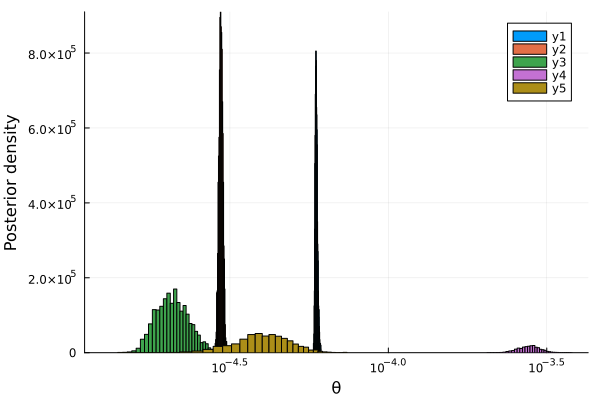

In [42]:
bootPars = bootFits.posterior
nbins = 50
histogram(bootPars, bins = nbins, xaxis = :log, norm = :pdf)
plot!(xlabel = "θ", ylabel = "Posterior density")

In [43]:
bootFits.BCquantiles

5×2 Matrix{Float64}:
 0.0361795   0.983126
 0.0309378   0.979951
 0.00849781  0.937378
 0.00686846  0.927284
 0.00975476  0.943435

In [44]:
bootFits.BCbias

5-element Vector{Float64}:
  0.08155573793071842
  0.04638925570538985
 -0.21341920772919243
 -0.2520531265622944
 -0.18784265122468308

Compute bias corrected posterior cdf

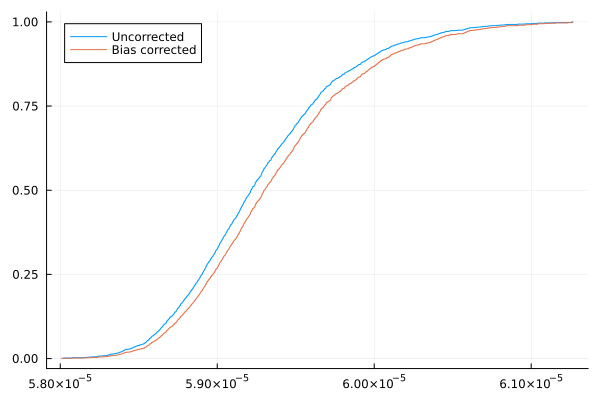

In [45]:
j = 1
v, z0 = bootFits.posterior[:,j], bootFits.BCbias[j]
Ghat = map(ecdf(v), v)
z = quantile(Normal(), Ghat) .- z0
w = zeros(length(v))
for k = 1:length(w)
    w[k] = isinf(z[k]) ? 1 : pdf(Normal(), z[k] - z0)/pdf(Normal(), z[k] + z0)
end
wtcdf = ecdf(v, weights = w)

x = sort(v)
y1 = map(ecdf(v), x)
y2 = map(wtcdf, x)
plot(x, y1, seriestype = :steppost, label = "Uncorrected")
plot!(x, y2, seriestype = :steppost, label = "Bias corrected")

In [46]:
bootFits.fit[j]

5.925848778770514e-5

In [47]:
ecdf(v)(bootFits.fit[j])

0.5325

In [48]:
wtcdf(bootFits.fit[j])

0.4676587362440752

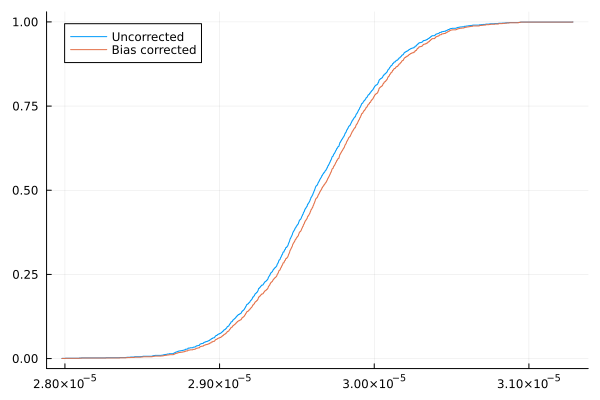

In [49]:
j = 2
v, z0 = bootFits.posterior[:,j], bootFits.BCbias[j]
uwcdf = ecdf(v)
Ghat = uwcdf.(v)
z = quantile(Normal(), Ghat) #.- z0
w = zeros(length(v))
for k = 1:length(w)
    w[k] = isinf(z[k]) ? 1 : pdf(Normal(), z[k] - z0)/pdf(Normal(), z[k] + z0)
end
wtcdf = ecdf(v, weights = w)

x = sort(v)
y1 = uwcdf.(x)
y2 = wtcdf.(x)
plot(x, y1, seriestype = :steppost, label = "Uncorrected")
plot!(x, y2, seriestype = :steppost, label = "Bias corrected")

In [50]:
bootFits.BayesCI

5×2 Matrix{Float64}:
 5.84828e-5   6.06291e-5
 2.88056e-5   3.04926e-5
 1.64081e-5   2.55295e-5
 0.000229583  0.000312163
 2.41153e-5   5.53821e-5

In [51]:
bootFits.fit[j]

2.963402111221346e-5

In [52]:
uwcdf(bootFits.fit[j])

0.5185

In [53]:
wtcdf(bootFits.fit[j])

0.4815894390535173

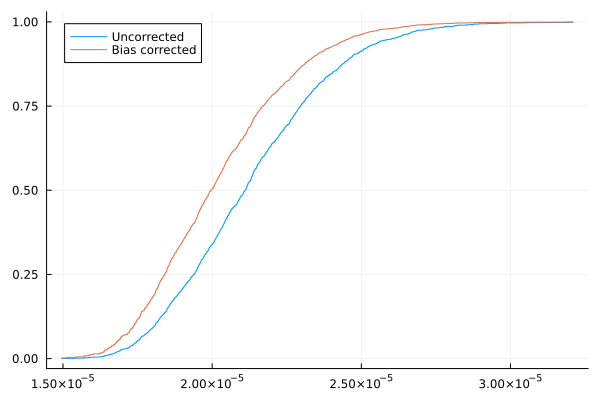

In [54]:
j = 3
v, z0 = bootFits.posterior[:,j], bootFits.BCbias[j]
Ghat = map(ecdf(v), v)
z = quantile(Normal(), Ghat) .- z0
w = zeros(length(v))
for k = 1:length(w)
    w[k] = isinf(z[k]) ? 1 : pdf(Normal(), z[k] - z0)/pdf(Normal(), z[k] + z0)
end
wtcdf = ecdf(v, weights = w)

x = sort(v)
y1 = map(ecdf(v), x)
y2 = map(wtcdf, x)
plot(x, y1, seriestype = :steppost, label = "Uncorrected")
plot!(x, y2, seriestype = :steppost, label = "Bias corrected")

More plots:
- Corner plot of bootstrap histograms + 2D histograms
- Prediction envelopes